In [1]:
# fnames_behavioral = ['../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd', '../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd']
# fnames_cs_indices = ['../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv', '../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv']

In [2]:
sess_indices = [4,5,48,49,56,58,59,60,61,64,66,69,70,74]


In [3]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt
import numpy as np
from kaveh.toolbox import find_files_regex
import pandas as pd
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
import numpy as np
import csv

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [6]:
experiments_csv = '../data/tetrode-heptode-ephys_recording_notes - Sheet1.csv'

df = pd.read_csv(experiments_csv)
exp_info = df[['date','OE', 'EL', 'CH']].dropna()

sessions_info = []
behavioral_source_dir = '../data/behavioral/'
OE_source_dir = '../data/OpenEphys_data/'
fnames = []
for idx, (_, row) in enumerate(exp_info.iterrows()):
    print(idx)
    recording_date = row['date']
    sess_EL = row['EL']
    sess_OE = row['OE']
    chan = row['CH']
    OE_source = os.path.join(OE_source_dir, recording_date, recording_date + '_' + sess_OE)
    behavioral_file  = find_files_regex(os.path.join(behavioral_source_dir, recording_date.replace('-','_')), r".*{}\.fhd$".format(sess_EL.replace('-','')))
    curr_sess = (chan,)
    if len(behavioral_file) == 1:
        print(behavioral_file[0])
        curr_sess = (behavioral_file[0],) + curr_sess
    elif len(behavioral_file) > 1:
        raise ValueError('multiple behavioral files found for the same timestamp: {}'.format(behavioral_file))
    else:
        print('Behavioral file not found: {}'.format(sess_EL))
    if os.path.exists(OE_source):
        print(OE_source)
        curr_sess = (OE_source,) + curr_sess
    else:
        print('Open Ephys directory not found: {}'.format(OE_source))
    sessions_info = sessions_info + [curr_sess]
    print('-------------------')

0
../data/behavioral/2019_08_12/random_corrective_saccades_140142.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-01-39
-------------------
1
../data/behavioral/2019_08_12/random_corrective_saccades_142257.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-22-55
-------------------
2
../data/behavioral/2019_08_12/random_corrective_saccades_144317.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-43-14
-------------------
3
../data/behavioral/2019_08_12/random_corrective_saccades_150416.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-04-14
-------------------
4
../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54
-------------------
5
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50
-------------------
6
../data/behavioral/2019_08_12/random_corrective_saccades_163652.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-36-49
------------

In [7]:
sessions_analyzed = [sessions_info[i] for i in sess_indices]

In [8]:
fnames_behavioral = [sa[1] for sa in sessions_analyzed]

In [9]:
fnames_cs_indices = [os.path.join(sa[0], 'channel_{}.CS.csv'.format(sa[2]-1)) for sa in sessions_analyzed]

In [10]:
fnames_cs_indices

['../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-04-12/2019-04-12_12-07-02/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-12/2019-04-12_12-20-25/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-15/2019-04-15_15-38-18/channel_0.CS.csv',
 '../data/OpenEphys_data/2019-04-24/2019-04-24_16-04-07/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-24/2019-04-24_15-33-57/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-26/2019-04-26_13-19-12/channel_0.CS.csv',
 '../data/OpenEphys_data/2019-05-01/2019-05-01_14-16-16/channel_2.CS.csv',
 '../data/OpenEphys_data/2019-05-15/2019-05-15_13-52-33/channel_3.CS.csv',
 '../data/OpenEphys_data/2019-05-16/2019-05-16_14-49-04/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-07-24/2019-07-24_14-10-24/channel_3.CS.csv',
 '../data/OpenEphys_data/2019-07-24/2019-07-24_14-29-39/channel_4.CS.csv',
 '../data/OpenEphys_data/

In [11]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    """
    Function for finding reaction times to targets
    """
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump + 0.025 and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [28]:
from scipy.io import loadmat
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

    
rt_for_file = {}
rt_toffs_for_file = {}
rt_toff_indices_for_file = {}

cs_counts_for_file = {}
cs_probs_for_file = {}
bin_sizes_for_file = {}

rt_mean_for_file = {}
rt_std_for_file = {}

for i,fn in enumerate(fnames_behavioral):
    print(fn)
    input_fn_mat = fn + '.session.mat'
    input_fn_session = fn + '.session.pkl'
    data = loadmat(input_fn_mat)
    with open(input_fn_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    
    (rt, rt_toffs, rt_toff_indices) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(data['non_iss_target_jumps_with_following_iss_tj']))
    
    with open(fnames_cs_indices[i], 'r') as csv_f:
        reader = csv.reader(csv_f)
        cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))
    
    rt_for_file[fn] = rt
    rt_toffs_for_file[fn] = rt_toffs
    rt_toff_indices_for_file[fn] = rt_toff_indices
    # [25, 40, 60, 75, 90]]
    bin_edges = [np.percentile(rt,q) for q in [25, 40, 60, 75, 90]]
    bin_ind_sac_delays = np.digitize(rt, bins = bin_edges)    
    rt_mean_for_file[fn] = [np.mean(rt[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_std_for_file[fn] = [np.std(rt[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, rt_toffs, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_indices/30000.0)
    cs_counts_for_file[fn] = cs_counts
    cs_probs_for_file[fn] = cs_probs
    bin_sizes_for_file[fn] = bin_sizes

    


../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_120703.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_122026.fhd
../data/behavioral/2019_04_15/random_corrective_saccades_153820.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_160409.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_153400.fhd
../data/behavioral/2019_04_26/random_corrective_saccades_131916.fhd
../data/behavioral/2019_05_01/random_corrective_saccades_141618.fhd
../data/behavioral/2019_05_15/random_corrective_saccades_135236.fhd
../data/behavioral/2019_05_16/random_corrective_saccades_144904.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_141028.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_142944.fhd
../data/behavioral/2019_04_03/random_corrective_saccades_141321.fhd


In [29]:
# fnames_cs_indices[5]

In [30]:
#  with open(fnames_cs_indices[4], 'r') as csv_f:
#         reader = csv.reader(csv_f)
#         cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

In [31]:
# cs_indices.shape

In [32]:
cs_prob_mat = np.array([s for s in cs_probs_for_file.values()])

rt_mean_mat = np.array([s for s in rt_mean_for_file.values()])

cs_prob_mean = np.mean(cs_prob_mat, axis = 0)
cs_prob_se = np.std(cs_prob_mat, axis = 0)/np.sqrt(cs_prob_mat.shape[0])

rt_mean_mean = np.mean(rt_mean_mat, axis = 0)
rt_mean_se = np.std(rt_mean_mat, axis = 0)/np.sqrt(rt_mean_mat.shape[0])



<IPython.core.display.Javascript object>


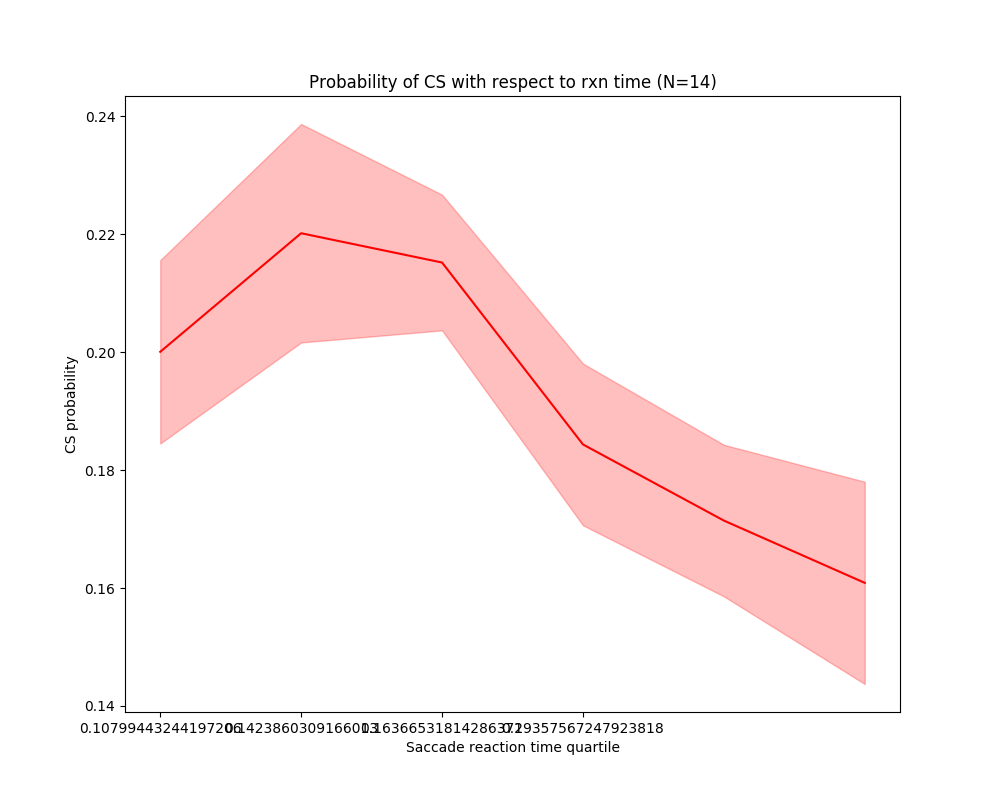

Text(0.5, 1.0, 'Probability of CS with respect to rxn time (N=14)')

In [17]:
import matplotlib.pyplot as plt
center = range(len(bin_edges)+1)
f1 = plt.figure(figsize=(10,8))
plt.plot(cs_prob_mean, 'r')
plt.fill_between(center, cs_prob_mean - cs_prob_se, cs_prob_mean + cs_prob_se, color='r', alpha=0.25)

# plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q3'])
plt.xlabel('Saccade reaction time quartile')
plt.ylabel('CS probability')
plt.xticks([0,1,2,3], rt_mean_mean)

plt.title('Probability of CS with respect to rxn time (N={})'.format(len(fnames_behavioral)))


<IPython.core.display.Javascript object>


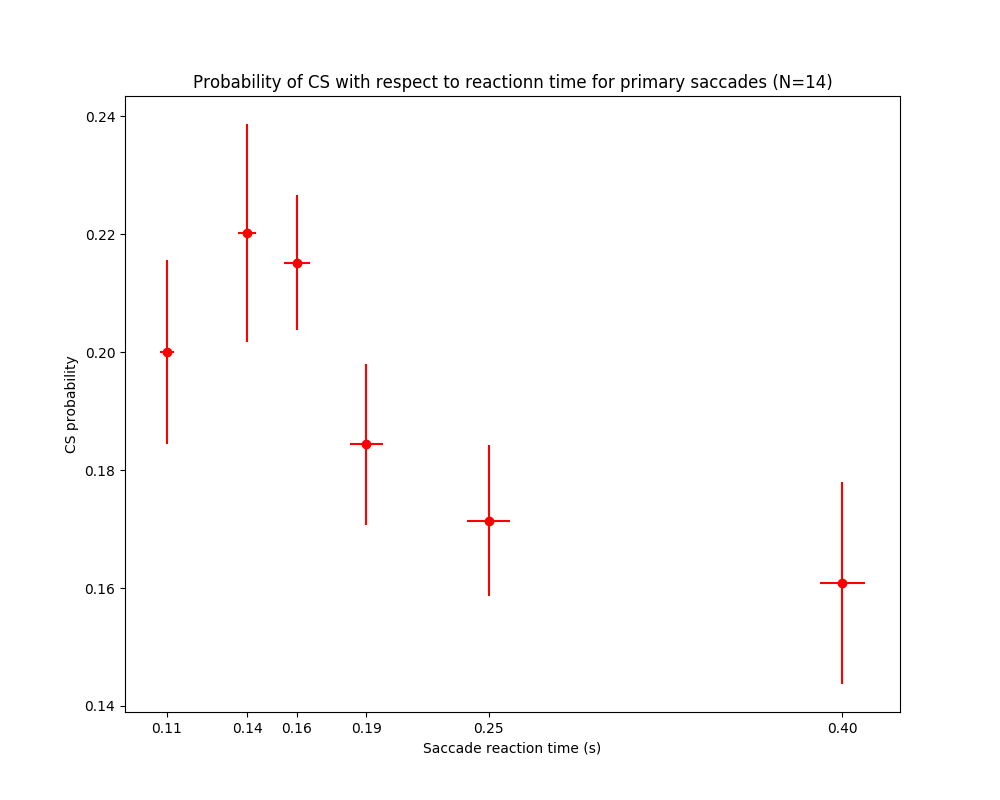

In [33]:
from matplotlib.ticker import FormatStrFormatter

f2 = plt.figure(figsize=(10,8))
ax = plt.errorbar(rt_mean_mean, cs_prob_mean, yerr=cs_prob_se, xerr=rt_mean_se, fmt='o', color='r')[0]

plt.xticks(rt_mean_mean)
plt.xlabel('Saccade reaction time (s)')
plt.ylabel('CS probability')
plt.title('Probability of CS with respect to reactionn time for primary saccades (N={})'.format(len(fnames_behavioral)))
ax.axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [20]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_CS_prob_vs_reaction_time_n14.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_CS_prob_vs_reaction_time_n14.svg')